In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteP59GC1/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteP59GC1/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


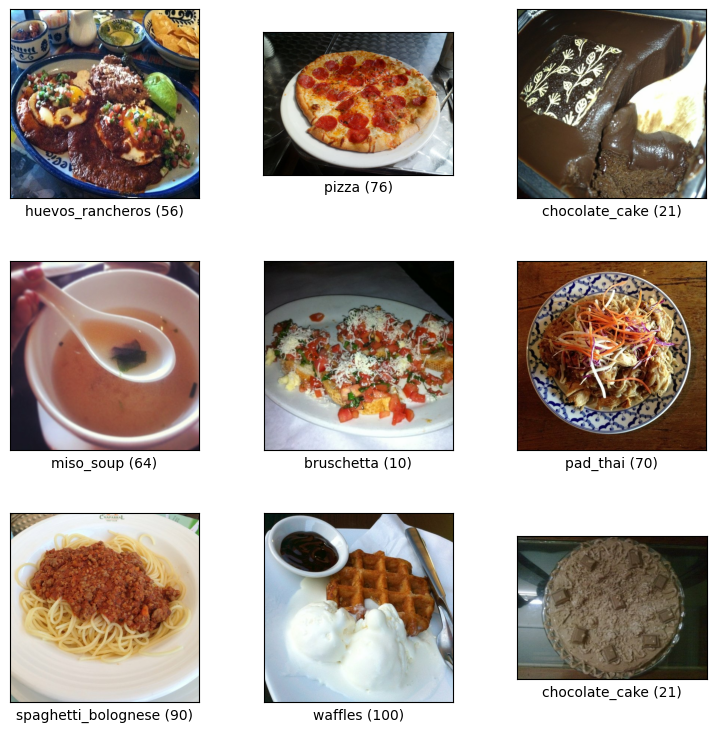

In [ ]:
fig = tfds.show_examples(train_data, ds_info)

In [ ]:
class_names = ds_info.features['label'].names

class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Resizing image to 224x224 and converting uint8 to float16
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [ ]:
train_data = train_data.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
from keras import layers
from keras.layers.experimental import preprocessing

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)

for layer in base_model.layers:
    layer.trainable=False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax")(x)

model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(factor=0.2,monitor='val_accuracy',min_lr=1e-7,patience=0,verbose=1)
early_stop = EarlyStopping(restore_best_weights=True,monitor='val_accuracy',patience=3)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy","sparse_top_k_categorical_accuracy"])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 101)               206949    
                                                                 
 activation_285 (Activation  (None, 101)               0   

In [ ]:
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[early_stop,reduce_lr])

Epoch 1/20
2368/2368 [==============================] - 190s 76ms/step - loss: 2.8584 - accuracy: 0.3563 - sparse_top_k_categorical_accuracy: 0.6171 - val_loss: 1.9175 - val_accuracy: 0.5209 - val_sparse_top_k_categorical_accuracy: 0.7815 - lr: 0.0010
Epoch 2/20
2368/2368 [==============================] - 183s 76ms/step - loss: 2.3810 - accuracy: 0.4488 - sparse_top_k_categorical_accuracy: 0.7200 - val_loss: 1.8632 - val_accuracy: 0.5299 - val_sparse_top_k_categorical_accuracy: 0.7985 - lr: 0.0010
Epoch 3/20
2368/2368 [==============================] - 178s 74ms/step - loss: 2.2914 - accuracy: 0.4711 - sparse_top_k_categorical_accuracy: 0.7397 - val_loss: 1.9009 - val_accuracy: 0.5305 - val_sparse_top_k_categorical_accuracy: 0.7908 - lr: 0.0010
Epoch 4/20
2368/2368 [==============================] - ETA: 0s - loss: 2.2505 - accuracy: 0.4811 - sparse_top_k_categorical_accuracy: 0.7521
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============

In [ ]:
model.save("/content/drive/My Drive/food_v6.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


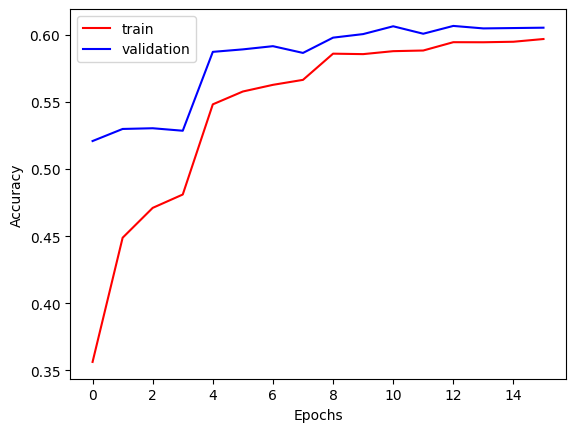

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

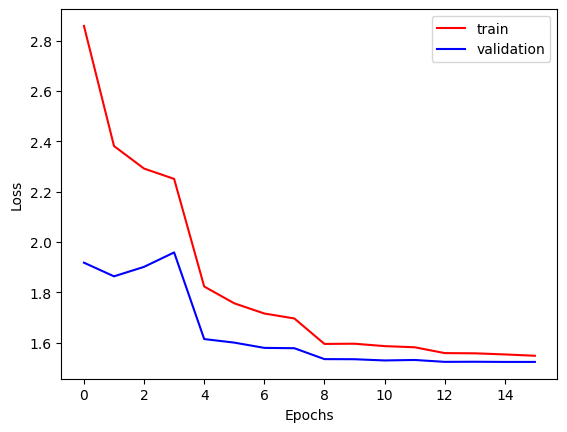

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

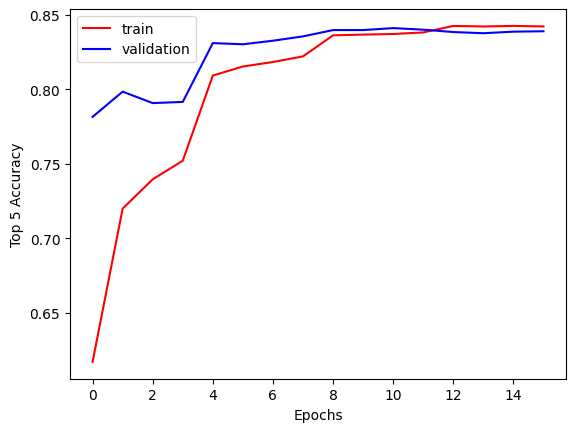

In [ ]:
plt.plot(history.history['sparse_top_k_categorical_accuracy'],color='red',label='train')
plt.plot(history.history['val_sparse_top_k_categorical_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top 5 Accuracy')
plt.show()

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 58s 71ms/step


In [ ]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([29, 81, 91, 53, 97, 31, 48, 31,  3, 30])

In [ ]:
# Getting true labels for the test_data
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
# Predicted vs True labels
pred_classes==y_labels

array([ True,  True,  True, ..., False,  True,  True])

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.6043564356435643

In [ ]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (100, 100));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues').set_title('Confusion Matrix').set_size(120);

plt.savefig('/content/drive/MyDrive/cnf_matrix_resnet.png', bbox_inches='tight')

In [ ]:
from sklearn.metrics import classification_report

report = (classification_report(y_labels, pred_classes, output_dict=True))

In [ ]:
class_f1_scores = {}
class_precision = {}

for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-score/precision to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
    class_precision[class_names[int(k)]] = v["precision"]

In [ ]:
class_f1_scores

{'apple_pie': 0.3182897862232779,
 'baby_back_ribs': 0.6277665995975856,
 'baklava': 0.6484375,
 'beef_carpaccio': 0.6284584980237153,
 'beef_tartare': 0.43145161290322576,
 'beet_salad': 0.4397705544933078,
 'beignets': 0.7701375245579567,
 'bibimbap': 0.7850098619329388,
 'bread_pudding': 0.34249471458773784,
 'breakfast_burrito': 0.4468546637744034,
 'bruschetta': 0.4370860927152318,
 'caesar_salad': 0.576271186440678,
 'cannoli': 0.6560636182902585,
 'caprese_salad': 0.5429141716566867,
 'carrot_cake': 0.5330490405117272,
 'ceviche': 0.3502109704641351,
 'cheesecake': 0.4461538461538462,
 'cheese_plate': 0.5806451612903225,
 'chicken_curry': 0.46511627906976744,
 'chicken_quesadilla': 0.6081632653061225,
 'chicken_wings': 0.6309523809523809,
 'chocolate_cake': 0.509090909090909,
 'chocolate_mousse': 0.4081632653061225,
 'churros': 0.712871287128713,
 'clam_chowder': 0.72265625,
 'club_sandwich': 0.6059479553903346,
 'crab_cakes': 0.44763860369609854,
 'creme_brulee': 0.724409448818

In [ ]:
class_precision

{'apple_pie': 0.391812865497076,
 'baby_back_ribs': 0.631578947368421,
 'baklava': 0.6335877862595419,
 'beef_carpaccio': 0.62109375,
 'beef_tartare': 0.4349593495934959,
 'beet_salad': 0.42124542124542125,
 'beignets': 0.7567567567567568,
 'bibimbap': 0.77431906614786,
 'bread_pudding': 0.3632286995515695,
 'breakfast_burrito': 0.4881516587677725,
 'bruschetta': 0.4876847290640394,
 'caesar_salad': 0.5444839857651246,
 'cannoli': 0.6521739130434783,
 'caprese_salad': 0.5418326693227091,
 'carrot_cake': 0.5707762557077626,
 'ceviche': 0.3705357142857143,
 'cheesecake': 0.42962962962962964,
 'cheese_plate': 0.5523465703971119,
 'chicken_curry': 0.49327354260089684,
 'chicken_quesadilla': 0.6208333333333333,
 'chicken_wings': 0.6259842519685039,
 'chocolate_cake': 0.5142857142857142,
 'chocolate_mousse': 0.4166666666666667,
 'churros': 0.7058823529411765,
 'clam_chowder': 0.7061068702290076,
 'club_sandwich': 0.5659722222222222,
 'crab_cakes': 0.459915611814346,
 'creme_brulee': 0.713178

In [ ]:
sorted_f1 = {k: v for k, v in sorted(class_f1_scores.items(), key=lambda item: item[1], reverse=True)}

sorted_f1

{'edamame': 0.9558232931726908,
 'macarons': 0.901639344262295,
 'hot_and_sour_soup': 0.8616600790513834,
 'dumplings': 0.8565737051792829,
 'miso_soup': 0.844181459566075,
 'pho': 0.8294573643410852,
 'seaweed_salad': 0.8218623481781376,
 'oysters': 0.8199233716475095,
 'frozen_yogurt': 0.8198019801980198,
 'cup_cakes': 0.8115384615384615,
 'bibimbap': 0.7850098619329388,
 'mussels': 0.7841584158415841,
 'french_fries': 0.7821229050279329,
 'onion_rings': 0.7775628626692457,
 'spaghetti_carbonara': 0.7751004016064257,
 'beignets': 0.7701375245579567,
 'escargots': 0.7698574338085539,
 'sashimi': 0.7686424474187381,
 'pizza': 0.7490347490347491,
 'red_velvet_cake': 0.7291242362525459,
 'creme_brulee': 0.7244094488188976,
 'clam_chowder': 0.72265625,
 'pad_thai': 0.7225130890052355,
 'guacamole': 0.7154471544715447,
 'churros': 0.712871287128713,
 'poutine': 0.7115384615384615,
 'deviled_eggs': 0.7112810707456979,
 'hot_dog': 0.7034220532319393,
 'spaghetti_bolognese': 0.703252032520325

In [ ]:
sorted_precision = {k: v for k, v in sorted(class_precision.items(), key=lambda item: item[1], reverse=True)}

sorted_precision

{'edamame': 0.9596774193548387,
 'macarons': 0.9243697478991597,
 'dumplings': 0.8531746031746031,
 'hot_and_sour_soup': 0.8515625,
 'miso_soup': 0.8326848249027238,
 'seaweed_salad': 0.8319672131147541,
 'frozen_yogurt': 0.8117647058823529,
 'pho': 0.8045112781954887,
 'oysters': 0.7867647058823529,
 'escargots': 0.7842323651452282,
 'cup_cakes': 0.7814814814814814,
 'spaghetti_carbonara': 0.7782258064516129,
 'mussels': 0.7764705882352941,
 'bibimbap': 0.77431906614786,
 'beignets': 0.7567567567567568,
 'onion_rings': 0.7528089887640449,
 'red_velvet_cake': 0.7427385892116183,
 'sashimi': 0.7362637362637363,
 'french_fries': 0.7317073170731707,
 'guacamole': 0.7272727272727273,
 'ice_cream': 0.7264150943396226,
 'pizza': 0.7238805970149254,
 'spring_rolls': 0.7155963302752294,
 'spaghetti_bolognese': 0.7148760330578512,
 'creme_brulee': 0.7131782945736435,
 'clam_chowder': 0.7061068702290076,
 'churros': 0.7058823529411765,
 'takoyaki': 0.7033898305084746,
 'waffles': 0.6897959183673

In [ ]:
f1score_df = pd.DataFrame(list(sorted_f1.items()), columns=['Key', 'Values'])
precisions_df = pd.DataFrame(list(sorted_precision.items()), columns=['Key', 'Values'])

In [ ]:
f1score_df.head()

,Key,Values
0,edamame,0.955823
1,macarons,0.901639
2,hot_and_sour_soup,0.861660
3,dumplings,0.856574
4,miso_soup,0.844181


In [ ]:
precisions_df.head()

,Key,Values
0,edamame,0.959677
1,macarons,0.924370
2,dumplings,0.853175
3,hot_and_sour_soup,0.851562
4,miso_soup,0.832685


In [ ]:
def preprocess(filename, img_shape=224, scale=True):
    # Read image
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    # Resize image to 224x224
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img/255.
    else:
        return img

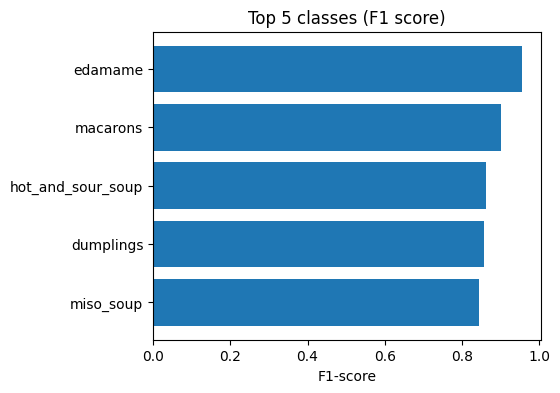

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
scores = ax.barh(range(5), f1score_df["Values"][:5].values)
ax.set_yticks(range(5))
ax.set_yticklabels(f1score_df["Key"][:5])
ax.set_xlabel("F1-score")
ax.set_title("Top 5 classes (F1 score)")
ax.invert_yaxis();

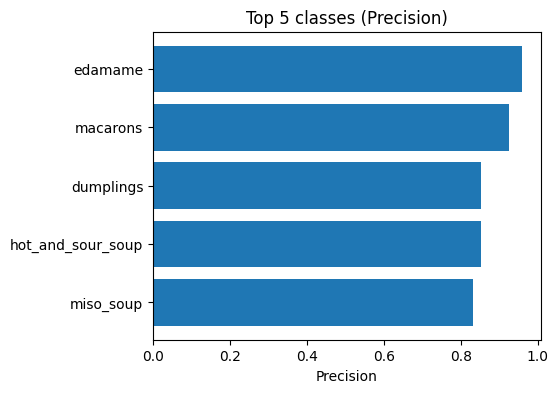

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
scores = ax.barh(range(5), precisions_df["Values"][:5].values)
ax.set_yticks(range(5))
ax.set_yticklabels(precisions_df["Key"][:5])
ax.set_xlabel("Precision")
ax.set_title("Top 5 classes (Precision)")
ax.invert_yaxis();

In [ ]:
import os

custom_food_images = ["/content/drive/MyDrive/food_images/" + img_path for img_path in os.listdir("/content/drive/MyDrive/food_images/")]
custom_food_images

['/content/drive/MyDrive/food_images/samosa.jpeg',
 '/content/drive/MyDrive/food_images/download.jpeg']

In [ ]:
def img_top5_plot(folder_path):
  custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path)]
  i=0
  fig,a = plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)-3))

  for img in custom_food_images:
    img = preprocess(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    top_5_i = (pred_prob.argsort())[0][-5:][::-1]
    values = pred_prob[0][top_5_i]
    labels = []
    for x in range(5):
      labels.append(class_names[top_5_i[x]])

    # Plotting Image
    a[i][0].imshow(img/255.)
    a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
    a[i][0].axis(False)

    # Plotting Models Top 5 Predictions
    a[i][1].bar(labels, values, color='blue');
    a[i][1].set_title('Top 5 Predictions')
    i=i+1

1/1 [==============================] - 0s 24ms/step


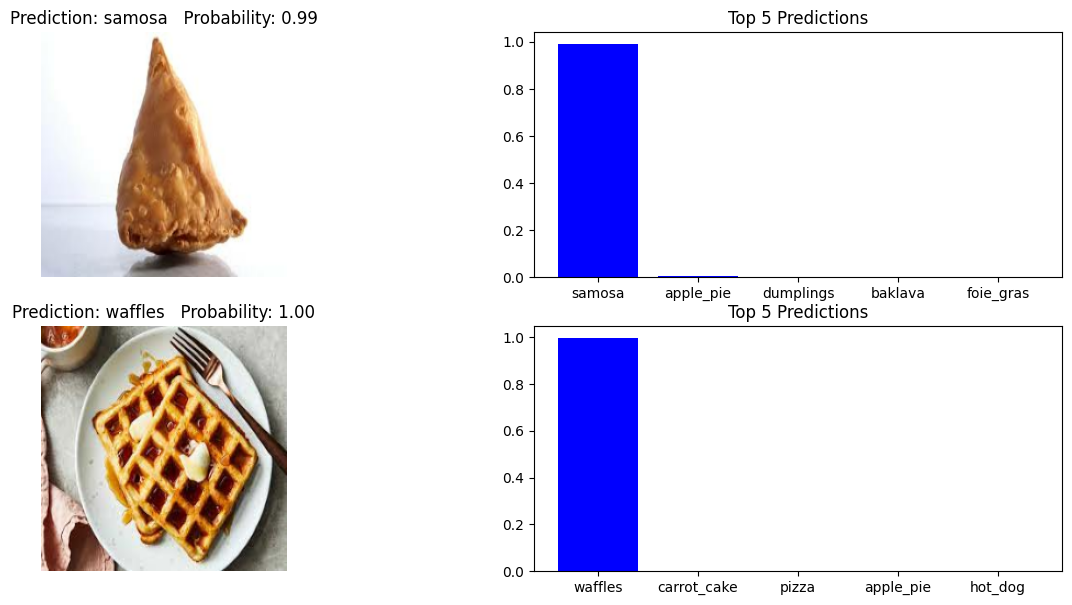

In [ ]:
img_top5_plot("/content/drive/MyDrive/food_images/")

In [ ]:
img = '/content/drive/MyDrive/food_images/samosa.jpeg'

img = preprocess(img, scale=False)
pred_prob = model.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_prob.argmax()]

1/1 [==============================] - 0s 37ms/step


In [ ]:
print(f"Prediction: {pred_class}, Confidence: {pred_prob.max():.2f}")

Prediction: samosa, Confidence: 0.99


In [ ]:
import google.generativeai as genai
genai.configure(api_key='your_key_here')
model_gen = genai.GenerativeModel('gemini-pro')

In [ ]:
specification = input("Would you like any specification for your recipe? ")

Would you like any specification for your recipe? traditional


In [ ]:
content = "Give me a recipe for " + specification + " " + pred_class
response = model_gen.generate_content(content)

print(response.text)

**Ingredients:**

**For the Dough:**

* 2 cups all-purpose flour
* 1/2 teaspoon salt
* 1/2 cup vegetable oil
* 1/4 cup cold water

**For the Filling:**

* 1 pound potatoes, peeled and diced
* 1 medium onion, chopped
* 1 green bell pepper, chopped
* 1/2 teaspoon ground cumin
* 1/2 teaspoon ground coriander
* 1/2 teaspoon turmeric
* 1/4 teaspoon red chili powder
* 1 tablespoon chopped fresh cilantro
* 1 teaspoon salt
* 1/4 cup vegetable oil

**Instructions:**

**To Make the Dough:**

1. In a large bowl, combine the flour and salt.
2. Add the oil and rub it into the flour until it resembles coarse crumbs.
3. Add the water a little at a time, mixing until the dough just comes together.
4. Form the dough into a ball, wrap it in plastic wrap, and let it rest for at least 30 minutes.

**To Make the Filling:**

1. In a large skillet, heat the vegetable oil over medium heat.
2. Add the onion and bell pepper and cook until softened, about 5 minutes.
3. Add the potatoes, cumin, coriander, turmeri